[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nasa-gcn/circulars-nlp-paper/blob/main/topic-modeling/notebooks/gravitational-wave_focused_clusters.ipynb)

#**Topic Modeling of GCN Circulars with Gravitational-Wave Focused Labels**
This project applies BERTopic and a fine-tuned transformer language model to analyze General Coordinates Network (GCN) Circulars, with an emphasis on gravitational-wave focused reports. The objective is to automatically identify, cluster, and interpret astrophysical topics related to GW detections and their electromagnetic counterparts within the unstructured GCN database.

##**Methodology**

The analysis combines unsupervised topic modeling with contrastive fine-tuning for targeted classification:

- **Model:** Fine-tuned all-MiniLM-L6-v2 using a balanced dataset of 300 Circulars (100 per label).

- **Labels:** Gravitational Wave (GW), Gravitational Wave Counterpart (GW-C), Non-Gravitational Wave (Non-GW)

- **Framework:** Contrastive learning with an 80–20 train–test split.

- **Runtime:** 1 epoch on Google Colab (T4 GPU), completed in approximately 1 hour.

- **Post-processing:** Cluster interpretation and topic labeling via BERTopic, using
SentenceTransformers for semantic embeddings,
UMAP for dimensionality reduction,
HDBSCAN for unsupervised clustering and
LLMs (e.g., Mistral 7B) for human-readable topic summaries.

## ⚙️ Setup Instructions

- This notebook is designed for Google Colab.  
- Before running, create a free [HuggingFace account](https://huggingface.co/) and generate an access token.  
- Store the token in Colab’s Secrets as `HF_LOGIN_TOKEN` and enable notebook access (guide: [Using secrets in Colab](https://drlee.io/how-to-use-secrets-in-google-colab-for-api-key-protection-a-guide-for-openai-huggingface-and-c1ec9e1277e0)).  


## ⚠️ Runtime Notes

- For reproducible results, run all cells sequentially and only once.  
- Re-running without restarting the runtime may lead to small variations due to the stochastic nature of UMAP and HDBSCAN
- We recommend using Colab’s L4 GPU runtime (available with Colab Pro, ~$10/month), which was used in our outputs. Other GPU runtimes will also work but may yield slight deviations.

#STEP 1: Download and Unzip Necessary Files. Install necessary libraries

In [1]:
!wget https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/data/archive_2025.json.tar.gz -O /content/archive_2025.json.tar.gz
!wget https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/data/custom_stopwords.txt -O /content/custom_stopwords.txt
!wget https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/topic-modeling/fine-tuned-models/gravitational-wave_tuned_mini_lm_epoch1.zip -O /content/gravitational-wave_tuned_mini_lm_epoch1.zip

--2025-10-08 21:11:42--  https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/data/archive_2025.json.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27323287 (26M) [application/octet-stream]
Saving to: ‘/content/archive_2025.json.tar.gz’

/content/archive_20 100%[===================>]  26.06M   153MB/s    in 0.2s    

2025-10-08 21:11:43 (153 MB/s) - ‘/content/archive_2025.json.tar.gz’ saved [27323287/27323287]

--2025-10-08 21:11:43--  https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/data/custom_stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443.

In [2]:
!unzip /content/gravitational-wave_tuned_mini_lm_epoch1.zip -d /content/gravitational_counterpart_tuned_mini_lm_1
!mv /content/gravitational_counterpart_tuned_mini_lm_1/gravitational_counterpart_tuned_mini_lm_1/* /content/gravitational_counterpart_tuned_mini_lm_1
!rm -rf /content/gravitational_counterpart_tuned_mini_lm_1/gravitational_counterpart_tuned_mini_lm_1


%pip install bertopic==0.16.2 -qqq

Archive:  /content/gravitational-wave_tuned_mini_lm_epoch1.zip
   creating: /content/gravitational_counterpart_tuned_mini_lm_1/gravitational_counterpart_tuned_mini_lm_1/
   creating: /content/gravitational_counterpart_tuned_mini_lm_1/gravitational_counterpart_tuned_mini_lm_1/1_Pooling/
  inflating: /content/gravitational_counterpart_tuned_mini_lm_1/gravitational_counterpart_tuned_mini_lm_1/1_Pooling/config.json  
   creating: /content/gravitational_counterpart_tuned_mini_lm_1/gravitational_counterpart_tuned_mini_lm_1/2_Normalize/
  inflating: /content/gravitational_counterpart_tuned_mini_lm_1/gravitational_counterpart_tuned_mini_lm_1/config.json  
  inflating: /content/gravitational_counterpart_tuned_mini_lm_1/gravitational_counterpart_tuned_mini_lm_1/config_sentence_transformers.json  
  inflating: /content/gravitational_counterpart_tuned_mini_lm_1/gravitational_counterpart_tuned_mini_lm_1/model.safetensors  
  inflating: /content/gravitational_counterpart_tuned_mini_lm_1/gravitationa

#Step 2: Extract GCN Circulars

In [3]:
'''
(a) Extract circular JSONs from tar file.
(b) Extract circular bodies from JSON list.
'''
import tarfile
import json
import os

with tarfile.open('./archive_2025.json.tar.gz', 'r') as file:
  file.extractall(path='./all_gcn_circulars')

dir = os.listdir('./all_gcn_circulars/archive.json') # Store all file names as strings in dir

# Add file path to beginning of file names in dir
dir = ['./all_gcn_circulars/archive.json/' + filename for filename in sorted(dir)]

print(f'Number of Circular JSONs: {len(dir)}\n')
print(f'First JSON path is: {dir[0]}')

circulars = []
circular_bodies = []
time_stamps = []
for file in dir:
  with open(file, encoding='utf-8') as f:
    data = json.load(f)
    circulars.append(data)
    circular_bodies.append(data["subject"]+data["body"])
    time_stamps.append(data["createdOn"])

print(f'The first circular is:\n {circulars[0]}\n')
print(f'The first circular body is:\n {circular_bodies[0]}')

/tmp/ipython-input-1715085099.py:10: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  file.extractall(path='./all_gcn_circulars')


Number of Circular JSONs: 40506

First JSON path is: ./all_gcn_circulars/archive.json/-1.json
The first circular is:
 {'subject': 'Possible new SGR from US Naval Observatory', 'editedOn': 1720124028651, 'version': 4, 'createdOn': 874022400000, 'editedBy': 'Vidushi Sharma at NASA GSFC/UMBC <vidushi.sharma@nasa.gov> on behalf of Tyler Barna at University of Minnesota <tylerpbarna@gmail.com>', 'submitter': 'Arne A. Henden at USNO/USRA <aah@nofs.navy.mil>', 'circularId': -1, 'email': 'circulars@gcn.nasa.gov', 'format': 'text/plain', 'body': 'The following report from A. Hendon et al. on the recent "possible new SGR"\n(ref IAUC 6743) has also been submitted to the IAUC:\n\n\nA. Henden, Universities Space Research Corporation (USRA) and U. S. Naval\nObservatory, Flagstaff Station (USNOFS)  aah@nofs.navy.mil\nC. Luginbuhl, USNOFS  cbl@nofs.navy.mil\nF. Vrba, USNOFS       fjv@nofs.navy.mil\nB. Canzian, USRA/USNOFS  bjc@nofs.navy.mil\nJ. Munn USNOFS           jam@nofs.navy.mil\nD. Hartmann, Cle

In [4]:
'''
Remove all undefined characters.
'''

clean_texts = []
for text in circular_bodies:
  clean_text = text.replace('�', '')
  clean_texts.append(clean_text)

circular_bodies = clean_texts

#Step 3: Generate Custom Stopwords List

In [5]:
'''
We will remove common English stopwords, punctuations, numbers, emails, and urls for preliminary statistical analysis and topic representations.
We will also remove a hand-selected list of stopwords that do not add any value to our topics.
As BERTopic uses a transformer based embedding model, it requires stopwords to build accurate embeddings.
So removing stopwords before this step is unadvised.
However, we can remove stopwords after embedding and clustering.
We will use sklearn's WordVectorizer for this.
'''
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords') # NLTK package for stopwords list

new_stop_words = []
new_stop_words = stopwords.words('english') # NLTK standard list of stopwords
punctuation_list = list(string.punctuation) # Standard list of punctuations
new_stop_words.extend(punctuation_list)

# Get list of numbers and urls in circulars
num_list = []
url_list = []
http_regex = re.compile(r"http.*")

for text in circular_bodies:
  word_list = text.split()

  for word in word_list:
    try:
      float(word) # Check if word is numeric. Throws Value Error otherwise
      num_list.append(word)
    except ValueError:
      pass

    if re.match(http_regex, word): # Check if word begins with http
      url_list.append(word)

# Get list of emails
email_list=[]
for circular in circulars:
  if "email" in circular:
    email_list.append(circular["email"])

num_list = list(set(num_list)) # Remove duplicates
new_stop_words.extend(num_list)

url_list = list(set(url_list))
new_stop_words.extend(url_list)

email_list = list(set(email_list))
new_stop_words.extend(email_list)

with open('custom_stopwords.txt') as f:
  for word in f:
    new_stop_words.append(word.lower().strip())

vectorizer_model = CountVectorizer(stop_words=new_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Step 4: Embed GCN Circulars With The Default all-MiniLM-L6-v2

In [6]:
'''
Embed our circulars using the base all-MiniLM-L6-v2 model.
'''
import numpy as np
from sentence_transformers import SentenceTransformer

# Default model. Really fast, but only has context window of 256 tokens
model = SentenceTransformer("all-MiniLM-L6-v2")
minilm_l6_embeddings = model.encode(circular_bodies, show_progress_bar=True)
np.save('minilm_l6_embeddings.npy', minilm_l6_embeddings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1266 [00:00<?, ?it/s]

#Step 5: Embedding Model Evaluation For Gravitational Wave Circular Classification

In [7]:
'''
We will now test a topic model on a small pre-defined dataset.
We have gathered GCN circulars belonging to the following categories:
  - Gravitational Wave
  - Gravitational Wave Counterpart
  - Non Gravitational Wave
In total we have 300 circulars in our dataset.
Our goal is to find the topic model that can correctly classify most of these circulars based on Zero-Shot Classification.
'''
from sklearn.model_selection import train_test_split

# Prepare dataset
gw = [38986, 38978, 38975, 38973, 38971, 38932, 38863, 38860, 38856, 38851,
38812, 38760, 38747, 38737, 38735, 38722, 38670, 38666, 38521, 38515,
38512, 38402, 38393, 38391, 38377, 38356, 38336, 38332, 38312, 38309,
38305, 38303, 38301, 38255, 38228, 38210, 38204, 38166, 38155, 38144,
38142, 38138, 38070, 38045, 38043, 38036, 37776, 37750, 37745, 37743,
37587, 37586, 37571, 37562, 37552, 37534, 37530, 37514, 37512, 37446,
37727, 37719, 37718, 37663, 37646, 37634, 37604, 37595, 37592, 37591,
37354, 37268, 37170, 37168, 37096, 36879, 36826, 36816, 36794, 36784,
36772, 36747, 36742, 36738, 36735, 36733, 36342, 20486, 20364, 19341,
18889, 18858, 18850, 18728, 18626, 18442, 21474, 21934, 21489, 21493]

gw_counterpart = [39009, 38993, 38957, 38939, 38783, 38757, 38748, 38745, 38742, 38679,
38493, 38443, 38417, 38396, 38370, 38351, 38348, 38345, 38334, 38333,
38324, 38317, 38316, 38308, 38272, 38231, 38169, 38168, 38156, 38154,
38151, 38146, 38102, 38101, 38056, 38044, 37884, 37777, 37699, 37644,
37621, 37611, 37609, 37590, 37589, 37528, 37527, 37454, 37451, 37448,
37440, 37381, 36972, 36924, 36871, 36850, 36837, 36800, 36793, 36755,
36705, 36698, 36688, 36610, 36579, 36571, 36565, 36526, 36495, 36468,
21503, 21497, 21481, 21477, 21476, 21475, 21890, 21885, 21878, 21860,
20402, 20399, 20398, 20395, 20393, 20390, 20376, 20371, 20370, 19315,
19055, 18870, 18834, 18813, 18776, 18621, 18451, 18448, 18446, 18359]

gw_false = [38725, 38724, 38658, 38610, 39040, 39039, 39038, 39037, 39036, 39035,
39034, 39033, 39032, 39031, 39030, 39029, 39028, 39028, 39023, 39018,
38841, 38842, 38843, 38844, 38845, 38846, 38847, 38848, 38849, 38850,
38852, 38853, 38854, 38855, 38857, 38858, 38746, 38749, 38750, 38753,
214,    215,    216,   217,    218,     314,   313,   312,   311,  310,
38754, 38740, 38739, 38738, 38736, 38730, 38727, 38540, 38539, 38538,
38537, 38536, 38535, 38534, 38529, 38439, 38438, 38437, 38436, 38435,
38434, 38241, 38242, 38245, 38246, 38247, 38248, 38239, 38235, 38234,
38229, 38219, 38220, 38221, 38222, 38212, 38205, 38206, 38207, 38208,
38088, 38089, 38090, 38091, 38092, 38093, 38094, 38095, 38096, 38097]

gw_train, gw_test = train_test_split(gw, test_size=0.2, random_state=0)

gw_counterpart_train, gw_counterpart_test = train_test_split(gw_counterpart, test_size=0.2, random_state=0)

gw_false_train, gw_false_test = train_test_split(gw_false, test_size=0.2, random_state=0)

train_observation_labels = []
test_observation_labels = []

# Get Training Set
for circular in circulars:
  if circular["circularId"] in gw_train:
    train_observation_labels.append("Gravitational Wave")
  elif circular["circularId"] in gw_counterpart_train:
    train_observation_labels.append("Gravitational Wave Counterpart")
  elif circular["circularId"] in gw_false_train:
    train_observation_labels.append("Not Gravitational Wave")
  else:
    train_observation_labels.append("")

# Get Test Set
for circular in circulars:
  if circular["circularId"] in gw_test:
    test_observation_labels.append("Gravitational Wave")
  elif circular["circularId"] in gw_counterpart_test:
    test_observation_labels.append("Gravitational Wave Counterpart")
  elif circular["circularId"] in gw_false_test:
    test_observation_labels.append("Not Gravitational Wave")
  else:
    test_observation_labels.append("")

print(len(train_observation_labels))
print(len(test_observation_labels))

print(len(gw_train))
print(len(gw_test))

print(len(gw_counterpart_train))
print(len(gw_counterpart_test))

print(len(gw_false_train))
print(len(gw_false_test))

40506
40506
80
20
80
20
80
20


In [8]:
'''
We will perform Zero-Shot Topic Modelling to match circulars to pre-defined cadidate labels.
We'll be using a cosine similarity with various thresholds to match topic labels to circulars.
For the circulars that don't match any of the labels above our threshold we perform regular Topic Modelling.
Finally, we calculate accuracy scores for each embedding model and cosine threshold based on our dataset.
'''
import pandas as pd
from umap import UMAP

embeddings_list = ["Base Model", "Epoch 1"]#, "Epoch 2", "Epoch 3"]
accuracy_scores = pd.DataFrame(index=["Train", "Test"], columns=embeddings_list)

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False,
                  random_state=0)

candidate_topics = ["Gravitational Wave", "Gravitational Wave Counterpart", "Not Gravitational Wave"]

In [9]:
'''
Compute accuracy for all-MiniLM-L6-v2 embeddings on training set
'''
from bertopic import BERTopic

vectorizer_model = CountVectorizer()
embeddings = np.load("minilm_l6_embeddings.npy")
model = SentenceTransformer("all-MiniLM-L6-v2")
error_count=0

# Compute accuracy scores based on number of matches between candidate labels and topic model labels
topic_model = BERTopic(verbose=True,
                       umap_model=umap_model,
                       vectorizer_model=vectorizer_model,
                       zeroshot_topic_list=candidate_topics,
                       zeroshot_min_similarity=0.1, # Assign topic to each circular if it crosses threshold
                       embedding_model=model)

topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

topic_labels=[]
for topic in topics:
  topic_labels.append(topic_model.topic_labels_[topic])

score = 0
for i, label in enumerate(train_observation_labels):
  if label != "":
    if topic_labels[i] == label:
      score += 1
    else:
      error_count += 1

print(f"Raw Score: {score}")
print(f"Raw Error: {error_count}")
accuracy = (score / (score + error_count)) * 100
accuracy_scores.at["Train", "Base Model"] = accuracy

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
2025-10-08 21:15:33,420 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-10-08 21:15:33,683 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-10-08 21:15:33,685 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-08 21:15:42,387 - BERTopic - Dimensionality - Completed ✓
2025-10-08 21:15:42,388 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-08 21:15:42,417 - BERTopic - Cluster - Completed ✓
2025-10-08 21:15:42,423 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-10-08 21:15:42,602 - BERTopic - Representation 

Raw Score: 56
Raw Error: 184


In [10]:

'''
Compute accuracy scores for base model on test set
'''

error_count=0

topic_model = BERTopic(verbose=True,
                      umap_model=umap_model,
                      vectorizer_model=vectorizer_model,
                      zeroshot_topic_list=candidate_topics,
                      zeroshot_min_similarity=0.1,
                      embedding_model=model)

topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

topic_labels=[]
for topic in topics:
  topic_labels.append(topic_model.topic_labels_[topic])

score = 0
for i, label in enumerate(test_observation_labels):
  if label != "":
    if topic_labels[i] == label:
      score += 1
    else:
      error_count += 1

print(f"Raw Score: {score}")
print(f"Raw Error: {error_count}")
accuracy = (score / (score + error_count)) * 100
accuracy_scores.at["Test", "Base Model"] = accuracy

accuracy_scores

2025-10-08 21:15:50,348 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-10-08 21:15:50,559 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-10-08 21:15:50,564 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-08 21:15:53,128 - BERTopic - Dimensionality - Completed ✓
2025-10-08 21:15:53,129 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-08 21:15:53,154 - BERTopic - Cluster - Completed ✓
2025-10-08 21:15:53,157 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-10-08 21:15:53,375 - BERTopic - Representation - Completed ✓
2025-10-08 21:15:53,603 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2025-10-08 21:15:53,620 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-08 21:15:53,623 - BERTopic - Dimensionality - Completed ✓
2025-10-08 21:15

Raw Score: 15
Raw Error: 45


,Base Model,Epoch 1
Train,23.333333,NaN
Test,25.0,NaN


#Step 6: Contrastive Fine-Tuning On Labelled Dataset (Do Not Run If You're Not Training)

In [ ]:
'''
We will now fine-tune our sentence embedder model using Contrastive Loss.
The goal is to fine-tune our embeddings so that circulars belong to similar topics are embedded more closely,
while circulars belonging to dissimilar topics are embedded far away in the vector space.
Theoretically this should help improve our zero-shot topic modelling accuracy.
We'll be using the same Gravitational Wave + Counterpart circular dataset as before.
'''

# Prepare Dataset
event_dataset = []
for text, label in zip(circular_bodies, train_observation_labels):
  example = {}
  if label != "":
    example["text"] = text
    example["label"] = candidate_topics.index(label)
    event_dataset.append(example)

# Add label names to event dataset as well
for label in candidate_topics:
  example = {}
  example["text"] = label
  example["label"] = candidate_topics.index(label)
  event_dataset.append(example)

print(len(event_dataset))
unique_values = {d["label"] for d in event_dataset if "label" in d}
print(unique_values)


# Prepare Similar Event Dataset
event_pair_dataset = []
for i in event_dataset:
  for j in event_dataset:
    # if i == j:
    #   continue
    example={}
    example["texts"] = [i["text"], j["text"]]
    if i["label"] == j["label"]:
      example["label"] = 1
    else:
      example["label"] = 0
    event_pair_dataset.append(example)

print(len(event_pair_dataset))

: 

In [ ]:
'''
Train for 1 epoch on the training set
'''
import torch
import random
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses

# Set seeds to help reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.use_deterministic_algorithms(True)

# Prepare Training Examples, Loss, and Model (all-MiniLM-L6-v2)
model = SentenceTransformer("all-MiniLM-L6-v2")
train_examples = [InputExample(texts=example["texts"], label=example["label"]) for example in event_pair_dataset]

# Prepare DataLoader Object
train_dataloader = DataLoader(train_examples,
                              shuffle=True,
                              batch_size=1,
                              num_workers=0)
train_size = len(train_dataloader)

# Use Contrastive Training Loss
train_loss = losses.ContrastiveLoss(model=model)

# Tune the model
model.old_fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=1,
          warmup_steps=100)

# Save the model
model.save("gravitational_counterpart_tuned_mini_lm_1")

: 

In [ ]:
# Get new all-MiniLM-L6-v2 embeddings
gravitational_counterpart_model_1 = SentenceTransformer("/content/gravitational_counterpart_tuned_mini_lm_1")
gravitational_counterpart_tuned_embeddings_1 = gravitational_counterpart_model_1.encode(circular_bodies, show_progress_bar=True)

: 

In [ ]:
'''
Compute training accuracy for fine-tuned all-MiniLM-L6-v2 embeddings
'''

error_count=0

# Compute accuracy scores based on number of matches between candidate labels and topic model labels
for i in range(1,2):
  embeddings = eval(f"gravitational_counterpart_tuned_embeddings_{i}")
  model = eval(f"gravitational_counterpart_model_{i}")
  topic_model = BERTopic(verbose=True,
                         umap_model=umap_model,
                         vectorizer_model=vectorizer_model,
                         zeroshot_topic_list=candidate_topics,
                         zeroshot_min_similarity=0.1,
                         embedding_model=model)

  topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

  topic_labels=[]
  for topic in topics:
    topic_labels.append(topic_model.topic_labels_[topic])

  score = 0
  error_count = 0
  for j, label in enumerate(train_observation_labels):
    if label != "":
      if topic_labels[j] == label:
        score += 1
      else:
        error_count += 1

  print(f"Raw Score for Epoch {i}: {score}")
  print(f"Raw Error for Epoch {i}: {error_count}")
  accuracy = (score / (score + error_count)) * 100
  epoch = f"Epoch {i}"
  accuracy_scores.at["Train", epoch] = accuracy

: 

In [ ]:
'''
Compute test accuracy for fine-tuned all-MiniLM-L6-v2 embeddings
'''

error_count=0

# Compute accuracy scores based on number of matches between candidate labels and topic model labels
for i in range(1,2):
  embeddings = eval(f"gravitational_counterpart_tuned_embeddings_{i}")
  model = eval(f"gravitational_counterpart_model_{i}")
  topic_model = BERTopic(verbose=True,
                         umap_model=umap_model,
                         vectorizer_model=vectorizer_model,
                         zeroshot_topic_list=candidate_topics,
                         zeroshot_min_similarity=0.1,
                         embedding_model=model)

  topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

  topic_labels=[]
  for topic in topics:
    topic_labels.append(topic_model.topic_labels_[topic])

  score = 0
  error_count = 0
  for j, label in enumerate(test_observation_labels):
    if label != "":
      if topic_labels[j] == label:
        score += 1
      else:
        error_count += 1

  print(f"Raw Score for Epoch {i}: {score}")
  print(f"Raw Error for Epoch {i}: {error_count}")
  accuracy = (score / (score + error_count)) * 100
  epoch = f"Epoch {i}"
  accuracy_scores.at["Test", epoch] = accuracy

  accuracy_scores

In [ ]:
'''
Create latex table for accuracy scores
'''

accuracy_latex_table = accuracy_scores.to_latex(float_format="%.2f")
accuracy_latex_table

#Step 7: Zero-Shot Topic Modelling For Gravitational Wave Circular Classification

In [11]:
# Get new all-MiniLM-L6-v2 embeddings
gravitational_counterpart_model_1 = SentenceTransformer("/content/gravitational_counterpart_tuned_mini_lm_1")
gravitational_counterpart_tuned_embeddings_1 = gravitational_counterpart_model_1.encode(circular_bodies, show_progress_bar=True)

Batches:   0%|          | 0/1266 [00:00<?, ?it/s]

In [12]:
'''
We'll now perform topic modelling again but with Zero-Shot enabled.
We will use our fine-tuned all-MiniLM-L6-v2 model for this which was tuned for 1 epoch on the gravitational wave dataset.
We attempt to fit our topics into pre-defined candidate labels using zero-shot topic modelling.
'''
candidate_topics = ["Gravitational Wave",
                    "Gravitational Wave Counterpart",
                    "Not Gravitational Wave"]

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False,
                  random_state=0)

# Build Topic Model with BERTopic
topic_model = BERTopic(verbose=True,
                       embedding_model=gravitational_counterpart_model_1,
                       umap_model=umap_model,
                       min_topic_size=100,
                       vectorizer_model=vectorizer_model,
                       zeroshot_topic_list=candidate_topics,
                       zeroshot_min_similarity=0.1)

topics, probs = topic_model.fit_transform(circular_bodies, gravitational_counterpart_tuned_embeddings_1)
topic_labels = [value for key, value in topic_model.topic_labels_.items()]
topic_model.set_topic_labels(topic_labels)

freq = topic_model.get_topic_info()
freq.head()

2025-10-08 21:18:09,230 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-10-08 21:18:09,409 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2025-10-08 21:18:09,428 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-08 21:18:09,430 - BERTopic - Dimensionality - Completed ✓
2025-10-08 21:18:09,508 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-08 21:18:09,522 - BERTopic - Cluster - Completed ✓
2025-10-08 21:18:09,532 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-10-08 21:18:24,486 - BERTopic - Representation - Completed ✓
2025-10-08 21:18:25,143 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-10-08 21:18:25,146 - BERTopic - Zeroshot Step 3 - Combining clustered topics with the zeroshot model


,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,36933,Not Gravitational Wave,Not Gravitational Wave,"[the, of, and, is, at, grb, in, with, al, et]",[GRB 090728: Swift detection of a burstV. Mang...
1,1,2884,Gravitational Wave Counterpart,Gravitational Wave Counterpart,"[the, of, and, 02, in, 2019, 10, master, 08, 17]",[LIGO/Virgo S200213t: No counterpart candidate...
2,2,689,Gravitational Wave,Gravitational Wave,"[the, ligo, is, and, sky, virgo, of, bayestar,...",[LIGO/Virgo/KAGRA S240908dg: Identification of...


In [13]:
'''
Create gravitational wave topic csv file
'''
from datetime import datetime

circular_topic_df = pd.DataFrame()
circular_topic_df["Circular ID"] = [item["circularId"] for item in circulars]
circular_topic_df["Subject"] = [item["subject"] for item in circulars]
circular_topic_df["Date"] = [datetime.utcfromtimestamp(item["createdOn"]/1000) for item in circulars]
circular_topic_df["Label"] = [topic_model.topic_labels_[i] for i in topics]

# Sort by Circular ID
circular_topic_df = circular_topic_df.sort_values(by="Circular ID")

circular_topic_df.head(10)

circular_topic_df.to_csv('gravitational_wave_topics.csv', index=False)

/tmp/ipython-input-1011473048.py:9: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  circular_topic_df["Date"] = [datetime.utcfromtimestamp(item["createdOn"]/1000) for item in circulars]


In [14]:
'''
Apply TSNE to reduce the dimensionality of the embeddings and visualize the clusters.
'''
from sklearn.manifold import TSNE
import plotly.graph_objects as go

reduced_embeddings = TSNE(n_components=2, n_jobs=1, random_state=0, verbose=2).fit_transform(gravitational_counterpart_tuned_embeddings_1)

fig = go.Figure()
tsne_df = pd.DataFrame()
tsne_df["x"], tsne_df["y"] = reduced_embeddings[:, 0], reduced_embeddings[:, 1]
tsne_df["topics"] = [topic_model.topic_labels_[i] for i in topics]
tsne_df["circular_id"] = circular_topic_df["Circular ID"]

G298048_GW170817 = [21505, 21506, 21507, 21508, 21509, 21510, 21511, 21513, 21514, 21515,
                    21516, 21518, 21519, 21521, 21522, 21524, 21525, 21526, 21527, 21528,
                    21529, 21530, 21531, 21532, 21533, 21534, 21535, 21536, 21537, 21538,
                    21539, 21541, 21542, 21543, 21544, 21545, 21546, 21547, 21548, 21549,
                    21550, 21551, 21552, 21553, 21554, 21555, 21556, 21557, 21558, 21559,
                    21560, 21561, 21562, 21563, 21564, 21565, 21566, 21567, 21568, 21569,
                    21570, 21571, 21572, 21574, 21575, 21576, 21577, 21578, 21579, 21580,
                    21581, 21582, 21583, 21584, 21585, 21586, 21587, 21588, 21589, 21590,
                    21591, 21592, 21594, 21595, 21596, 21597, 21598, 21599, 21603, 21606,
                    21608, 21609, 21610, 21612, 21613, 21614, 21617, 21618, 21619, 21620,
                    21621, 21623, 21624, 21625, 21626, 21627, 21628, 21629, 21631, 21632,
                    21633, 21634, 21635, 21636, 21637, 21638, 21639, 21641, 21644, 21645,
                    21648, 21650, 21653, 21664, 21669, 21670, 21671, 21672, 21674, 21676,
                    21677, 21680, 21681, 21682, 21683, 21684, 21685, 21686, 21687, 21695,
                    21703, 21708, 21740, 21744, 21746, 21747, 21750, 21760, 21763, 21765,
                    21768, 21778, 21779, 21780, 21781, 21783, 21785, 21786, 21787, 21798,
                    21803, 21804, 21814, 21815, 21816, 21833, 21842, 21848, 21850, 21851,
                    21882, 21883, 21886, 21889, 21891, 21894, 21895, 21897, 21898, 21899,
                    21900, 21908, 21914, 21920, 21927, 21929, 21931, 21933, 21935, 21939,
                    21940, 21975, 21982, 21983, 22201, 22203, 22206, 22207, 22211, 22368,
                    22371, 22372, 22374, 22692, 22693, 22763, 23137, 23139, 23140, 23986,
                    23987, 24000, 25631, 27357, 27411, 27414, 29019, 29038, 29041, 29053,
                    29055, 29263, 29375, 31187, 31231, 32065, 32094]

GW170817_df = tsne_df[tsne_df["circular_id"].isin(G298048_GW170817)]

for label in list(topic_model.topic_labels_.values()):
  sub_df = tsne_df.loc[tsne_df["topics"] == label]
  fig.add_trace(
    go.Scattergl(
      x=sub_df["x"],
      y=sub_df["y"],
      mode="markers",
      name=str(label[label.find('_')+1:]) + " (" + str(sub_df.shape[0]) + ")",
    )
  )
  # # Add annotation (topic label) at cluster centroid
  # centroid_x, centroid_y = np.median(sub_df["x"])+5.0, np.median(sub_df["y"])+5.0
  # print(centroid_x, centroid_y)
  # fig.add_annotation(
  #     x=centroid_x,
  #     y=centroid_y,
  #     text=str(label[label.find('_') + 1:]),  # <-- only label name
  #     showarrow=False,
  #     font=dict(size=15, color="black", family="Helvetica"),
  #     bgcolor="rgba(255,255,255,0.7)"
  # )

fig.add_trace(
  go.Scattergl(
    x=GW170817_df["x"],
    y=GW170817_df["y"],
    mode="markers",
    name=f"GW 170817 ({len(G298048_GW170817)})",
    marker=dict(
    color='yellow',
    opacity=1.0,
    size=7.5,
    symbol='diamond',
    line=dict(width=0.2, color='black')
    )
  )
)

# # Add annotation label for GW 170817
# if not GW170817_df.empty:
#     fig.add_annotation(
#         x=GW170817_df["x"].median()+5,
#         y=GW170817_df["y"].median()+5,
#         text="<b>GW 170817</b>",
#         showarrow=True,
#         arrowhead=2,
#         ax=30,
#         ay=-30,
#         font=dict(size=15, color="black", family="Helvetica"),
#         bgcolor="rgba(255,255,255,0.7)"
#     )

fig.update_traces(
  marker=dict(
    size=5,
    opacity=0.5,
  )
)

fig.update_layout(
  #   title={
  #   'text': "<b>General Coordinates Network (GCN): Observation-Based Topic Clusters</b>",
  #   'x': 0.5,
  #   'xanchor': 'center'
  # },
  width=1200,
  height=800,
  legend_title_text="Topics (Circular Counts)",
  legend=dict(
    x=1.05,
    y=1,
    traceorder='normal',
    bgcolor='rgba(0,0,0,0)',
    bordercolor='rgba(0,0,0,0)',
    font=dict(size=20)
  ),
  xaxis=dict(
    showticklabels=False
  ),
  yaxis=dict(
    showticklabels=False
  )
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40506 samples in 0.009s...
[t-SNE] Computed neighbors for 40506 samples in 45.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40506
[t-SNE] Computed conditional probabilities for sample 2000 / 40506
[t-SNE] Computed conditional probabilities for sample 3000 / 40506
[t-SNE] Computed conditional probabilities for sample 4000 / 40506
[t-SNE] Computed conditional probabilities for sample 5000 / 40506
[t-SNE] Computed conditional probabilities for sample 6000 / 40506
[t-SNE] Computed conditional probabilities for sample 7000 / 40506
[t-SNE] Computed conditional probabilities for sample 8000 / 40506
[t-SNE] Computed conditional probabilities for sample 9000 / 40506
[t-SNE] Computed conditional probabilities for sample 10000 / 40506
[t-SNE] Computed conditional probabilities for sample 11000 / 40506
[t-SNE] Computed conditional probabilities for sample 12000 / 40506
[t-SNE] Computed conditional probabilities for sa

In [15]:
fig = topic_model.visualize_heatmap(
    width=850,
    height=650,
    custom_labels=True
)

# Increase font sizes
fig.update_layout(
    font=dict(size=17)  # Controls all text in the figure
)

fig.show()

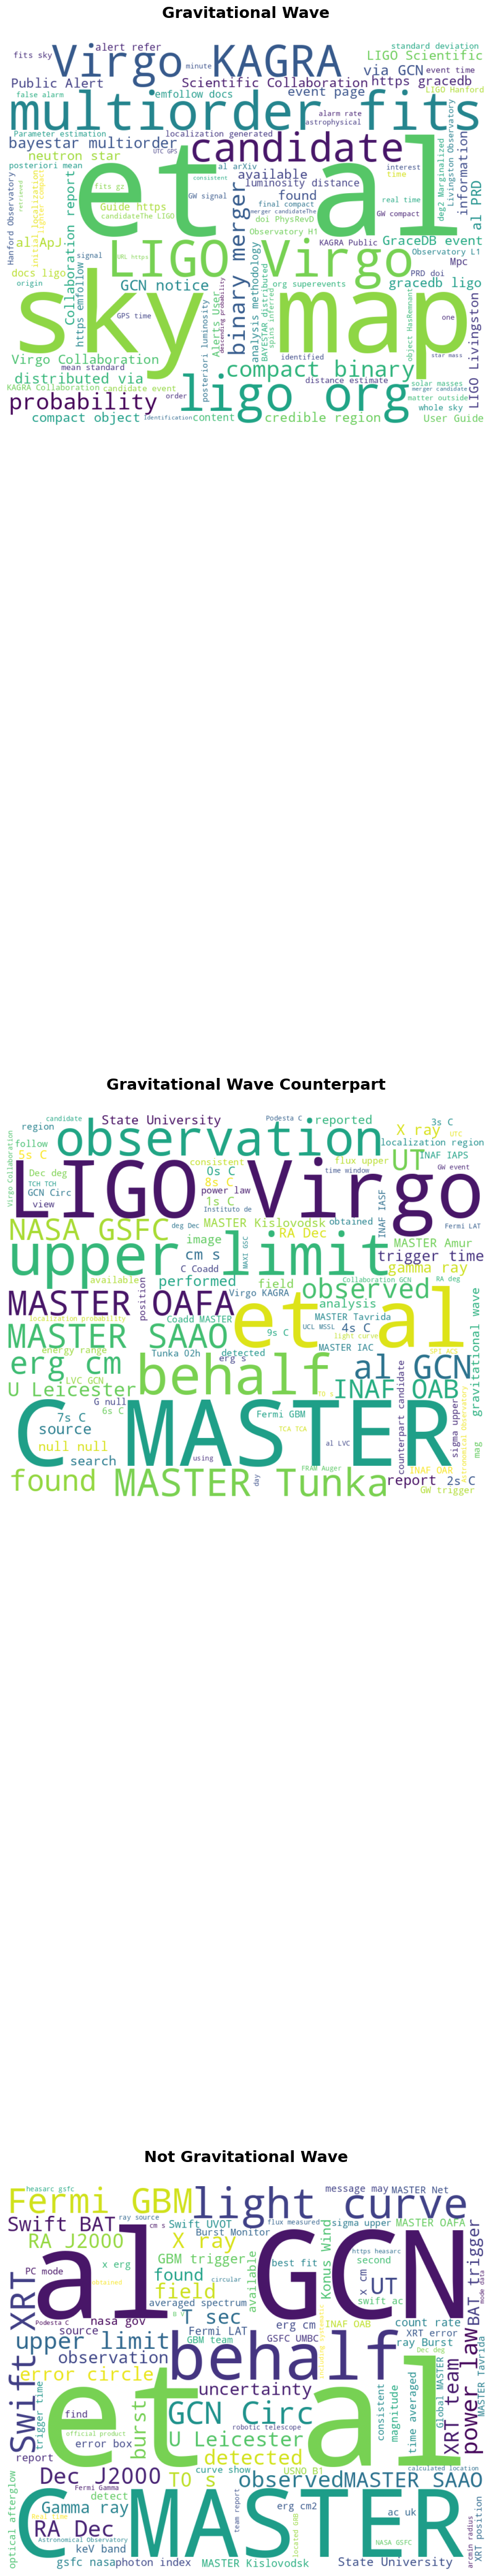

In [18]:
'''
Create word cloud over our candidate topics
'''
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axs = plt.subplots(len(candidate_topics), 1, figsize=(10, 60))

# Join all documents of a candidate topic together and generate word cloud
for topic_num, ax in enumerate(axs):
  word_cloud = WordCloud(
        collocations=True,
        background_color='white',
        max_words=100,
        width=1000,
        height=800).generate(' '.join([text for i, text in enumerate(circular_bodies) if topic_model.topic_labels_[topics[i]] == candidate_topics[topic_num]]))

  ax.imshow(word_cloud, interpolation='bilinear')
  ax.set_title(candidate_topics[topic_num], fontsize=18, fontweight="bold", y=1.05)
  ax.axis("off")

plt.subplots_adjust(hspace=0.5)
plt.show()

/tmp/ipython-input-330921568.py:24: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).



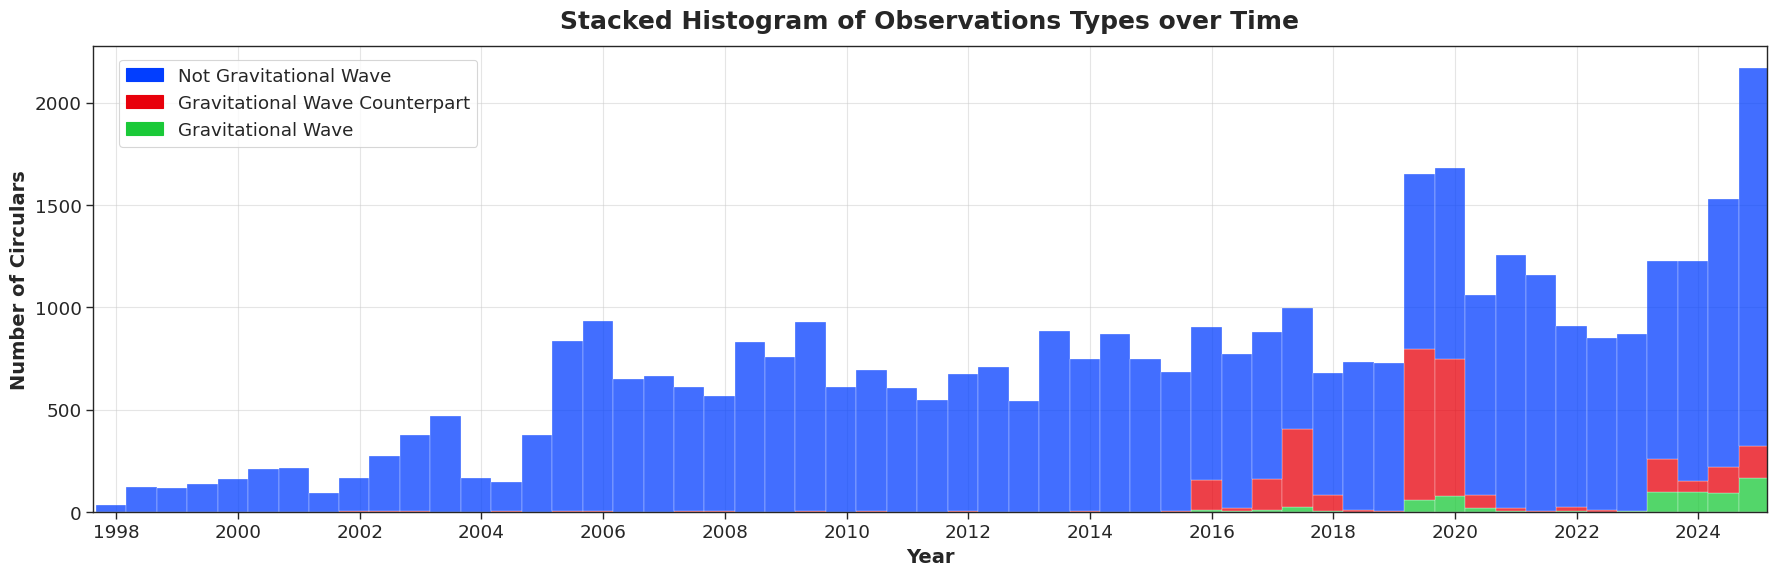

In [23]:
'''
We will now perform Trend Analysis over our Topic Clusters.
'''
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from datetime import datetime
import seaborn as sns

num_topics = len(freq)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(18, 6))
custom_colors = ['#023eff', '#e8000b', '#1ac938']
custom_palette =  sns.color_palette(custom_colors)

all_topic_dates = []
all_dates = [] # List to store all dates

# Iterate over all timestamps and check their respective document's topic
for i, time_stamp in enumerate(time_stamps):
  if time_stamp == 0: # Discard invalid dates
      continue
  date = datetime.utcfromtimestamp(time_stamp/1000)
  topic = topic_model.topic_labels_[topics[i]]
  all_topic_dates.append({'Date': date, 'Topic': topic})
  all_dates.append(date)

topic_dates_df = pd.DataFrame(all_topic_dates)
my_bins = pd.date_range(start=min(all_dates), end=max(all_dates), freq='6M')
sns.histplot(topic_dates_df,
             x='Date',
             hue='Topic',
             multiple="stack",
             bins=mdates.date2num(my_bins),
             alpha=0.75,
             linewidth=0.2,
             palette=custom_palette)

# Calculate the number of 6-month intervals between start and end dates
start_date = min(all_dates)
end_date = max(all_dates)
num_intervals = (end_date.year - start_date.year) * 2 + (end_date.month - start_date.month) // 6

# Calculate the adjusted end date based on the number of intervals
adjusted_end_date = start_date + pd.DateOffset(months=num_intervals * 6)

plt.xlim(start_date, adjusted_end_date)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Number of Circulars", fontsize=14, fontweight="bold")
#plt.title("Stacked Histogram of Observations Types over Time", fontsize=18, fontweight="bold", y=1.02)
plt.grid(axis="both", linestyle="-", alpha=0.5)
handles = [Patch(color=custom_colors[i], label=topic_model.topic_labels_[i]) for i in range(len(custom_colors))]
plt.legend(handles=handles, bbox_to_anchor=(0.01, 0.99), loc='upper left')

plt.tight_layout()
plt.show()

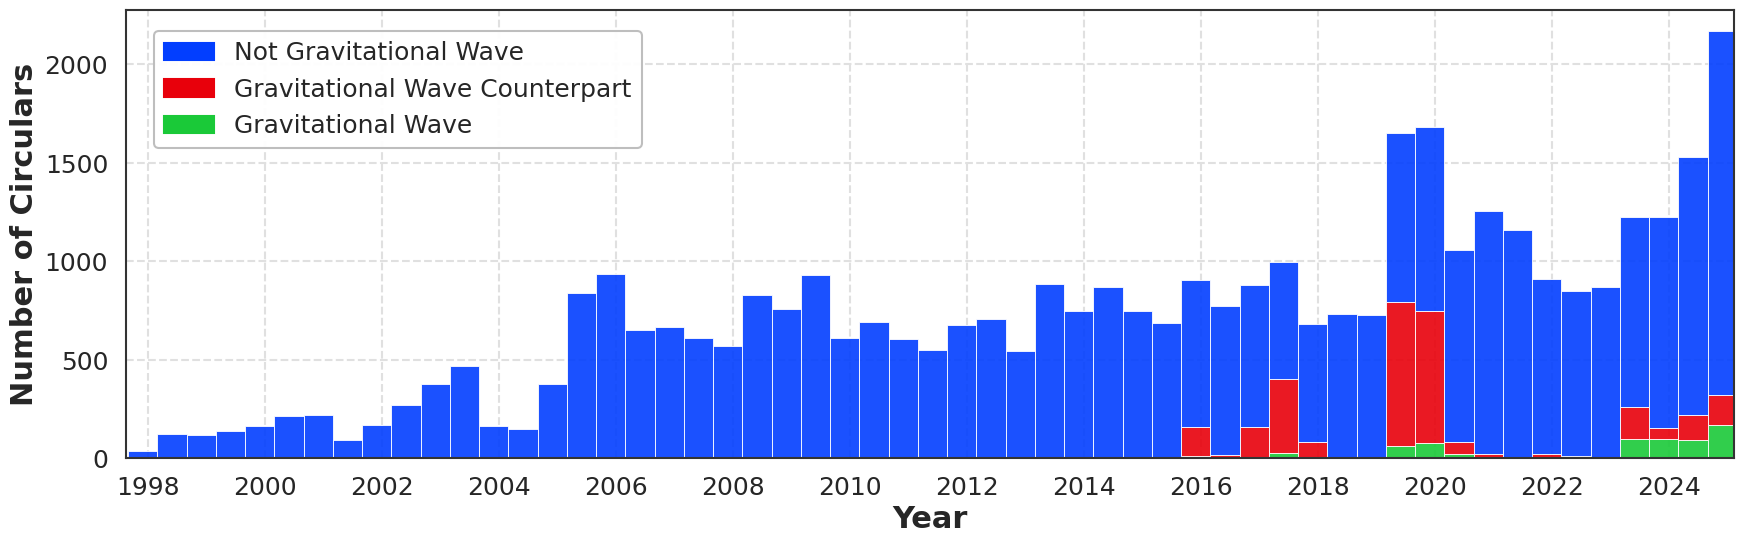

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import timezone

# --- Helvetica Elegant Theme with Larger Fonts ---

sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid", {
    'axes.edgecolor': '#333333',
    'grid.color': '#e0e0e0',
    'grid.linestyle': '--',
    'grid.linewidth': 0.8
})

# --- Figure Setup ---
plt.figure(figsize=(18, 6))
custom_colors = ['#023eff', '#e8000b', '#1ac938'] #custom_colors = ['#0052cc', '#e63946', '#06d6a0']  # Deep blue, red, mint green
custom_palette = sns.color_palette(custom_colors)

# --- Data Preparation ---
all_topic_dates = []
all_dates = []

for i, time_stamp in enumerate(time_stamps):
    if time_stamp == 0:
        continue
    date = datetime.fromtimestamp(time_stamp / 1000, tz=timezone.utc)#date = datetime.utcfromtimestamp(time_stamp / 1000)
    topic = topic_model.topic_labels_[topics[i]]
    all_topic_dates.append({'Date': date, 'Topic': topic})
    all_dates.append(date)

topic_dates_df = pd.DataFrame(all_topic_dates)

# --- Histogram Plot ---
my_bins = pd.date_range(start=min(all_dates), end=max(all_dates), freq='6M')
sns.histplot(
    topic_dates_df,
    x='Date',
    hue='Topic',
    multiple="stack",
    bins=mdates.date2num(my_bins),
    alpha=0.9,
    linewidth=0.6,
    palette=custom_palette,
    edgecolor='white'
)

# --- Axis Formatting ---
start_date = min(all_dates)
end_date = max(all_dates)
num_intervals = (end_date.year - start_date.year) * 2 + (end_date.month - start_date.month) // 6
adjusted_end_date = start_date + pd.DateOffset(months=num_intervals * 6)

# --- Axis Formatting ---
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlim(start_date, adjusted_end_date)
plt.xlabel("Year", fontweight="bold", fontsize=22)
plt.ylabel("Number of Circulars", fontweight="bold", fontsize=22)
# Decrease x and y tick label sizes
ax.tick_params(axis='x', labelsize=18)  # smaller x-axis ticks
ax.tick_params(axis='y', labelsize=18)  # smaller y-axis ticks


# --- Enclosed Box Style (visible spines) ---
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# --- Legend ---
handles = [Patch(color=custom_colors[i], label=topic_model.topic_labels_[i]) for i in range(len(custom_colors))]
legend = plt.legend(
    handles=handles,
    loc='upper left',
    bbox_to_anchor=(0.01, 0.98),
    frameon=True,
    edgecolor='#bbbbbb',
    fancybox=True,
    facecolor='white',
    fontsize=18  # smaller font size for topic labels
)
legend.get_frame().set_alpha(0.95)

# --- Final Layout ---
plt.tight_layout()
plt.show()

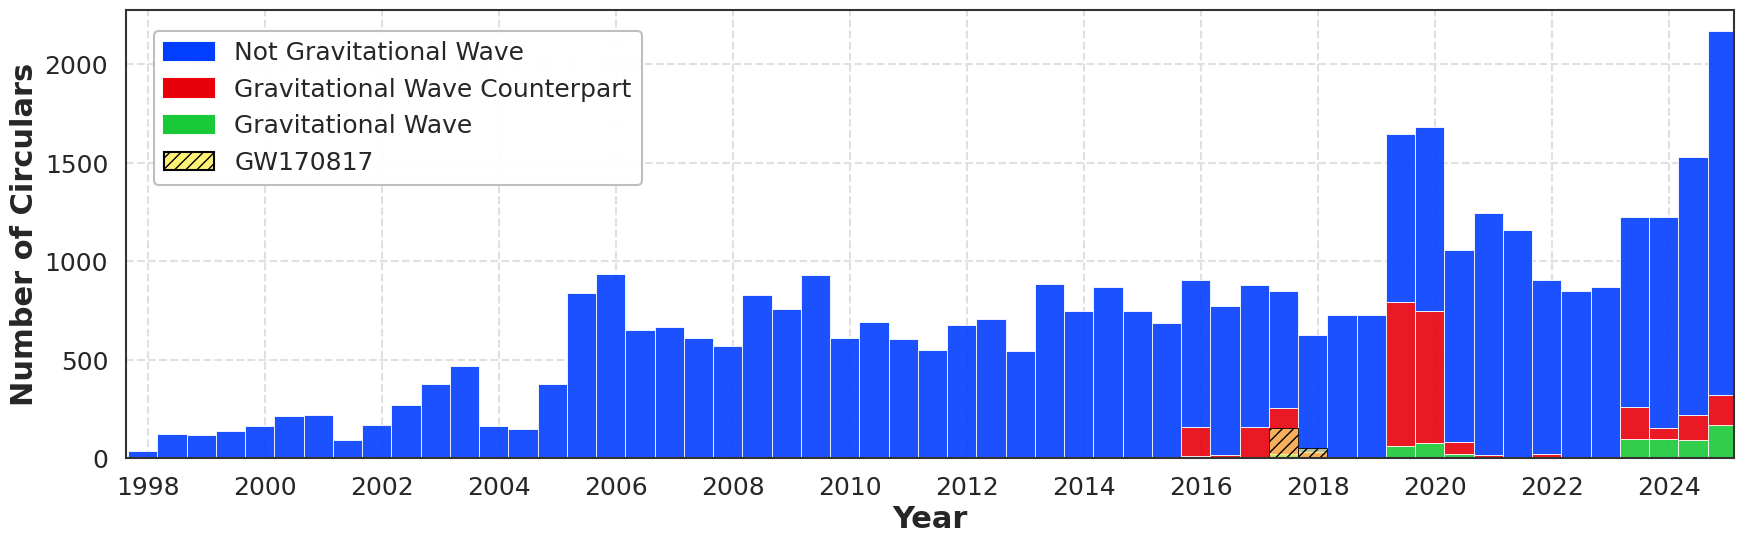

In [70]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from datetime import datetime, timezone
import seaborn as sns
import pandas as pd
import numpy as np

# --- Helvetica Elegant Theme with Larger Fonts ---
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid", {
    'axes.edgecolor': '#333333',
    'grid.color': '#e0e0e0',
    'grid.linestyle': '--',
    'grid.linewidth': 0.8
})

# --- Figure Setup ---
plt.figure(figsize=(18, 6))
custom_colors = ['#023eff', '#e8000b', '#1ac938']  # Original BERTopic colors
manual_color = '#fff176'  # Lighter yellow for GW170817

# --- Data Preparation ---
all_topic_dates = []
all_dates = []

for i, time_stamp in enumerate(time_stamps):
    if time_stamp == 0:
        continue
    date = datetime.fromtimestamp(time_stamp / 1000, tz=timezone.utc)
    topic = topic_model.topic_labels_[topics[i]]

    # Separate GW170817 manual circulars
    if circulars[i]['circularId'] in G298048_GW170817:
        all_topic_dates.append({'Date': date, 'Topic': 'GW170817'})
    else:
        all_topic_dates.append({'Date': date, 'Topic': topic})

    all_dates.append(date)

topic_dates_df = pd.DataFrame(all_topic_dates)

# --- Histogram Bins ---
my_bins = pd.date_range(start=min(all_dates), end=max(all_dates), freq='6M')

# --- Plot BERTopic Topics ---
sns.histplot(
    topic_dates_df[topic_dates_df['Topic'] != 'GW170817'],
    x='Date',
    hue='Topic',
    multiple="stack",
    bins=mdates.date2num(my_bins),
    alpha=0.9,
    linewidth=0.6,
    palette=custom_colors,
    edgecolor='white'
)

# --- Overlay GW170817 as Hatched Yellow ---
sns.histplot(
    topic_dates_df[topic_dates_df['Topic'] == 'GW170817'],
    x='Date',
    bins=mdates.date2num(my_bins),
    alpha=0.7,
    linewidth=0.6,
    color=manual_color,
    edgecolor='black',
    hatch='///',
    multiple="stack"
)

# --- Axis Formatting ---
start_date = min(all_dates)
end_date = max(all_dates)
num_intervals = (end_date.year - start_date.year) * 2 + (end_date.month - start_date.month) // 6
adjusted_end_date = start_date + pd.DateOffset(months=num_intervals * 6)

ax = plt.gca()
ax.set_xlim(start_date, adjusted_end_date)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel("Year", fontweight="bold", fontsize=22)
plt.ylabel("Number of Circulars", fontweight="bold", fontsize=22)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

# --- Enclosed Box Style ---
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('#333333')
    spine.set_linewidth(1.5)

# --- Legend with Hatch for GW170817 ---
handles = [Patch(color=custom_colors[i], label=topic_model.topic_labels_[i]) for i in range(len(custom_colors))]
handles.append(Patch(facecolor=manual_color, edgecolor='black', hatch='///', label='GW170817'))

legend = ax.legend(
    handles=handles,
    loc='upper left',
    bbox_to_anchor=(0.01, 0.98),
    frameon=True,
    edgecolor='#bbbbbb',
    fancybox=True,
    facecolor='white',
    fontsize=18
)
legend.get_frame().set_alpha(0.95)

# --- Final Layout ---
plt.tight_layout()
plt.show()


In [72]:
'''
Error Analysis: Get circulars in GW 170817 that were incorrectly classified as 'Not Gravitational Wave'
'''

incorrect_labels = []
gw_labels = []
gw_counterpart_labels = []
for i, circular in enumerate(circulars):
  if circular['circularId'] in G298048_GW170817:
    if topic_model.topic_labels_[topics[i]] == "Not Gravitational Wave":
      incorrect_labels.append(circular)
    elif topic_model.topic_labels_[topics[i]] == "Gravitational Wave":
      gw_labels.append(circular)
    elif topic_model.topic_labels_[topics[i]] == "Gravitational Wave Counterpart":
      gw_counterpart_labels.append(circular)

errors_df = pd.DataFrame()
errors_df["Circular ID"] = [item["circularId"] for item in incorrect_labels]
errors_df["Subject"] = [item["subject"] for item in incorrect_labels]

gw_df = pd.DataFrame()
gw_df["Circular ID"] = [item["circularId"] for item in gw_labels]
gw_df["Subject"] = [item["subject"] for item in gw_labels]

gw_counterpart_df = pd.DataFrame()
gw_counterpart_df["Circular ID"] = [item["circularId"] for item in gw_counterpart_labels]
gw_counterpart_df["Subject"] = [item["subject"] for item in gw_counterpart_labels]

print("Number of GW Labels: ", len(gw_labels))
print("Number of GW Counterpart Labels: ", len(gw_counterpart_labels))
print("Number of Incorrect Labels: ", len(incorrect_labels))
print(incorrect_labels)

errors_df.head()

Number of GW Labels:  6
Number of GW Counterpart Labels:  220
Number of Incorrect Labels:  1
[{'subject': 'Potential X-ray KN afterglow from Chandra observations of GW170817 ~3.3 years since merger (3 Epochs of 4)', 'bibcode': '2020GCN.29041....1H', 'createdOn': 1607968509000, 'circularId': 29041, 'submitter': 'Aprajita Hajela at Northwestern U  <AprajitaHajela2015@u.northwestern.edu>', 'email': 'AprajitaHajela2015@u.northwestern.edu', 'body': 'A. Hajela, R. Margutti, K. D. Alexander,  W. Fong  (Northwestern U.), T.\nLaskar (Bath), D. L. Coppejans (Northwestern U.), V. A. Villar (Columbia\nU.), D. Giannios (Purdue U.), T. Eftekhari (Harvard U.), L. Sironi\n(Columbia), B. Margalit (Berkeley) report:\n\nWe observed GW170817 with the Chandra X-ray Observatory (CXO) at t ~\n1209-1212 days (~3.3 years) after the binary neutron star merger. We report\nhere the preliminary results from the first three epochs acquired so far,\nfor a total exposure time of ~ 64 ks (out of a total of 100 ks requ

,Circular ID,Subject
0,29041,Potential X-ray KN afterglow from Chandra obse...
